<a href="https://colab.research.google.com/github/NichBry25/BitcoinPricePrediction/blob/main/BTCForecasting_GRU_Based_DeepVAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment and Imports

In [1]:
import os
os.environ["TF_DETERMINISTIC_OPS"] = "1"
os.environ["TF_CUDNN_DETERMINISTIC"] = "1"
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

In [2]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras import layers, models, callbacks
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import statsmodels.api as sm
from statsmodels.stats.contingency_tables import mcnemar
import scipy.stats as stats

# Reproducibility Utilities

In [3]:
def set_all_seeds(seed: int):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

In [4]:
def reset_tf():
    tf.keras.backend.clear_session()

# Data Loading

In [5]:
df = pd.read_csv('btc_forecasting_dataset3.csv')

In [6]:
df

,Date,btc_price,open,high,low,volume,spx_price,xau_price,vix_price,dxy_price,...,xau_logret_lag3,xau_logret_lag7,vix_logret_lag1,vix_logret_lag3,vix_logret_lag7,dxy_logret_lag1,dxy_logret_lag3,dxy_logret_lag7,btc_ma50,btc_ma200
0,2015-07-20,277.7,273.2,278.9,271.8,46600.0,2128.30,1096.95,12.25,98.03,...,-0.009696,-0.005134,0.000000,-0.013300,-0.191274,0.000000,0.001943,0.008606,252.782,246.4990
1,2015-07-21,275.1,277.7,281.0,274.2,49050.0,2119.20,1101.41,12.22,97.33,...,0.000000,-0.002135,0.024795,0.000000,-0.038875,0.001736,0.000000,-0.002274,253.822,246.2985
2,2015-07-22,276.5,275.1,277.4,273.1,41970.0,2114.20,1093.45,12.12,97.60,...,0.000000,-0.005102,-0.002452,0.000000,-0.010526,-0.007166,0.000000,0.005469,254.838,246.2455
3,2015-07-23,275.5,276.5,277.9,274.5,35660.0,2102.20,1090.80,12.64,97.11,...,-0.033306,-0.003922,-0.008217,0.024795,-0.088455,0.002770,0.001736,0.005132,255.836,246.2995
4,2015-07-24,288.4,275.5,289.8,274.3,74360.0,2079.70,1099.10,13.74,97.24,...,0.004058,-0.009696,0.042009,-0.002452,-0.013300,-0.005033,-0.007166,0.001943,257.120,246.3675
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3752,2025-10-27,114108.0,114553.9,116307.5,113868.0,70790.0,6875.16,3981.59,15.79,98.78,...,-0.003416,0.024755,0.000000,-0.055256,-0.130922,0.000000,0.000101,0.001624,114272.866,108948.3695
3753,2025-10-28,112905.8,114110.3,116076.7,112266.9,52490.0,6890.89,3952.58,16.42,98.67,...,0.000000,-0.054579,-0.036074,0.000000,-0.019945,-0.001720,0.000000,0.003443,114289.614,109095.8330
3754,2025-10-29,110024.6,112904.7,113628.7,109506.4,66990.0,6890.59,3930.38,16.92,99.22,...,0.000000,-0.007551,0.039123,0.000000,0.040038,-0.001114,0.000000,-0.000303,114259.776,109219.4925
3755,2025-10-30,108320.1,110024.9,111585.8,106371.4,80070.0,6822.34,4024.47,16.91,99.53,...,-0.032253,0.007810,0.029996,-0.036074,-0.072455,0.005559,-0.001720,0.000404,114146.908,109342.4210


Grouping columns with or without macroeconomic features based on number ("1" for WITHOUT, and "2" for WITH)

In [7]:
TARGET = 'btc_logret'

In [8]:
FEATURES_1 = [
    "btc_price", "open", "high", "low", "volume",
    "btc_ma50", "btc_ma200"
]

In [9]:
FEATURES_2 = [
    "btc_price","open","high","low","volume",
    "spx_price","xau_price","vix_price","dxy_price",
    "spx_logret","xau_logret","vix_logret","dxy_logret",
    "spx_logret_lag1","spx_logret_lag3","spx_logret_lag7",
    "xau_logret_lag1","xau_logret_lag3","xau_logret_lag7",
    "vix_logret_lag1","vix_logret_lag3","vix_logret_lag7",
    "dxy_logret_lag1","dxy_logret_lag3","dxy_logret_lag7",
    "btc_ma50","btc_ma200"
]

# Train - Val - Test Split

In [10]:
total_len = len(df)

In [11]:
train_end = int(total_len * 0.7)
val_end = int(total_len * 0.85)

train_df = df.iloc[:train_end].copy()
val_df   = df.iloc[train_end:val_end].copy()
test_df  = df.iloc[val_end:].copy()

In [12]:
train_df.shape

(2629, 29)

In [13]:
val_df.shape

(564, 29)

In [14]:
test_df.shape

(564, 29)

# Scale Features

In [15]:
scaler_1 = MinMaxScaler()

In [16]:
scaler_1.fit(train_df[FEATURES_1])

MinMaxScaler()

In [17]:
train_scaled_1 = scaler_1.transform(train_df[FEATURES_1])
val_scaled_1   = scaler_1.transform(val_df[FEATURES_1])
test_scaled_1  = scaler_1.transform(test_df[FEATURES_1])

In [18]:
scaler_2 = MinMaxScaler()

In [19]:
scaler_2.fit(train_df[FEATURES_2])

MinMaxScaler()

In [20]:
train_scaled_2 = scaler_2.transform(train_df[FEATURES_2])
val_scaled_2   = scaler_2.transform(val_df[FEATURES_2])
test_scaled_2  = scaler_2.transform(test_df[FEATURES_2])

In [22]:
# Target scaler
y_train_full = train_df[TARGET].values
y_val_full   = val_df[TARGET].values
y_test_full  = test_df[TARGET].values

In [23]:
target_scaler = StandardScaler()

In [24]:
target_scaler.fit(y_train_full.reshape(-1, 1))

StandardScaler()

In [25]:
y_train_scaled = target_scaler.transform(y_train_full.reshape(-1, 1)).ravel()
y_val_scaled   = target_scaler.transform(y_val_full.reshape(-1, 1)).ravel()
y_test_scaled  = target_scaler.transform(y_test_full.reshape(-1, 1)).ravel()

# Create Sequence

In [26]:
def make_sequence_data(values, target, lookback):
    X, y = [], []
    for i in range(lookback, len(values)):
        X.append(values[i - lookback:i])
        y.append(target[i])
    return np.array(X), np.array(y)

In [27]:
LOOKBACK = 60

In [28]:
X_train_1, y_train_1 = make_sequence_data(train_scaled_1, y_train_scaled, LOOKBACK)
X_val_1,   y_val_1   = make_sequence_data(val_scaled_1,   y_val_scaled,   LOOKBACK)
X_test_1,  y_test_1  = make_sequence_data(test_scaled_1,  y_test_scaled,  LOOKBACK)

In [29]:
X_train_2, y_train_2 = make_sequence_data(train_scaled_2, y_train_scaled, LOOKBACK)
X_val_2,   y_val_2   = make_sequence_data(val_scaled_2,   y_val_scaled,   LOOKBACK)
X_test_2,  y_test_2  = make_sequence_data(test_scaled_2,  y_test_scaled,  LOOKBACK)

In [30]:
y_test_unscaled = y_test_full[LOOKBACK:]

# Metrics

In [31]:
def calculate_performance_metrics(y_test, y_pred):
    mse  = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_test, y_pred)
    da   = np.mean((y_test * y_pred) > 0)
    return {"MSE": mse, "RMSE": rmse, "MAE": mae, "DA": da}

# Modelling

In [32]:
from itertools import product

In [33]:
GRID = {
    "units": [50, 100],
    "learning_rate": [0.001, 0.003],
    "batch_size": [32, 64],
    "patience": [5, 10],
}

grid_combinations = list(product(
    GRID["units"],
    GRID["learning_rate"],
    GRID["batch_size"],
    GRID["patience"]
))

In [34]:
len(grid_combinations)

16

In [35]:
def gaussian_nll(y_true, y_pred):

    y_true = tf.reshape(y_true, (-1, 1))

    mean, raw_var = tf.split(y_pred, 2, axis=-1)
    var = tf.nn.softplus(raw_var) + 1e-6

    # NLL for Gaussian
    nll = 0.5 * (tf.math.log(var) + tf.square(y_true - mean) / var)

    return tf.reduce_mean(nll, axis=-1)

In [36]:
def build_deepvar_gru(input_shape, units, learning_rate):
    inputs = layers.Input(shape=input_shape)
    x = layers.GRU(units, return_sequences=True)(inputs)
    x = layers.GRU(units)(x)
    x = layers.Dense(25, activation='relu')(x)

    outputs = layers.Dense(2)(x)  # mean and log_variance

    model = models.Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss=gaussian_nll
    )
    return model

In [37]:
results = []

In [ ]:
for i, (units, lr, batch_size, patience) in enumerate(grid_combinations, 1):
  print(f"\n[{i}/{len(grid_combinations)}] "
        f"units={units}, lr={lr}, "
        f"batch={batch_size}, patience={patience}")

  ## WITHOUT MACRO
  model_1 = build_deepvar_gru(X_train_1.shape[1:], units, lr)

  model_1.fit(
      X_train_1, y_train_1,
      epochs = 50,
      batch_size = batch_size,
      validation_data = (X_val_1, y_val_1),
      callbacks = [
          callbacks.EarlyStopping(
              patience=patience,
              restore_best_weights=True
          )
      ],
      verbose=0
  )

  y_pred_1_full = model_1.predict(X_test_1)
  y_pred_1_scaled = y_pred_1_full[:, 0]
  y_pred_1 = target_scaler.inverse_transform(y_pred_1_scaled.reshape(-1, 1)).ravel()

  metrics_1 = calculate_performance_metrics(y_test_unscaled, y_pred_1)

  ## WITH MACRO
  model_2 = build_deepvar_gru(X_train_2.shape[1:], units, lr)

  model_2.fit(
      X_train_2, y_train_2,
      epochs = 50,
      batch_size = batch_size,
      validation_data = (X_val_2, y_val_2),
      callbacks = [
          callbacks.EarlyStopping(
              patience=patience,
              restore_best_weights=True
          )
      ],
      verbose=0
  )

  y_pred_2_full = model_2.predict(X_test_2)
  y_pred_2_scaled = y_pred_2_full[:, 0]
  y_pred_2 = target_scaler.inverse_transform(y_pred_2_scaled.reshape(-1, 1)).ravel()

  metrics_2 = calculate_performance_metrics(y_test_unscaled, y_pred_2)

  results.append({
      "units": units,
      "learning_rate": lr,
      "batch_size": batch_size,
      "patience": patience,

      "MSE_1": metrics_1['MSE'],
      'MSE_2': metrics_2['MSE'],

      "RMSE_1": metrics_1["RMSE"],
      "RMSE_2": metrics_2["RMSE"],

      "MAE_1": metrics_1["MAE"],
      "MAE_2": metrics_2["MAE"],

      "DA_1": metrics_1["DA"],
      "DA_2": metrics_2["DA"],

      "Macro Better MSE": metrics_2["MSE"] < metrics_1["MSE"],
      "Macro Better RMSE": metrics_2["RMSE"] < metrics_1["RMSE"],
      "Macro Better MAE": metrics_2["MAE"] < metrics_1["MAE"],
      "Macro Better DA": metrics_2["DA"] > metrics_1["DA"],
  })


[1/16] units=50, lr=0.001, batch=32, patience=5
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step

[2/16] units=50, lr=0.001, batch=32, patience=10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step

[3/16] units=50, lr=0.001, batch=64, patience=5
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step

[4/16] units=50, lr=0.001, batch=64, patience=10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step

[5/16] units=50, lr=0.003, batch=32, patience=5
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step

[6/16] units=50, lr=0.003, batch=32, patience=10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step

[7/16] units=50, lr=0.003, batch=64, patience=5
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step

[8/16] units=50, lr=0.003, batch=64, patience=10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
16/1

# Results

In [ ]:
results_df = pd.DataFrame(results)

In [ ]:
results_df

,Unnamed: 0,units,learning_rate,batch_size,patience,MSE_1,MSE_2,RMSE_1,RMSE_2,MAE_1,MAE_2,DA_1,DA_2,Macro Better MSE,Macro Better RMSE,Macro Better MAE,Macro Better DA
0,0,50,0.001,32,5,0.000565,0.000565,0.023779,0.023765,0.017067,0.017048,0.496032,0.486111,True,True,True,False
1,1,50,0.001,32,10,0.000563,0.000593,0.023719,0.024348,0.016939,0.017795,0.513889,0.488095,False,False,False,False
2,2,50,0.001,64,5,0.000562,0.000570,0.023713,0.023869,0.017013,0.017197,0.500000,0.476190,False,False,False,False
3,3,50,0.001,64,10,0.000625,0.000569,0.024999,0.023850,0.018512,0.017068,0.488095,0.488095,True,True,True,False
4,4,50,0.003,32,5,0.000563,0.000646,0.023730,0.025423,0.016939,0.018980,0.500000,0.488095,False,False,False,False
5,5,50,0.003,32,10,0.000572,0.000569,0.023909,0.023851,0.017149,0.017293,0.488095,0.505952,True,True,False,True
6,6,50,0.003,64,5,0.000566,0.000567,0.023797,0.023816,0.017041,0.017131,0.488095,0.496032,False,False,False,True
7,7,50,0.003,64,10,0.000579,0.000562,0.024059,0.023709,0.017553,0.016933,0.511905,0.462302,True,True,True,False
8,8,100,0.001,32,5,0.000559,0.000570,0.023647,0.023883,0.016937,0.017215,0.525794,0.496032,False,False,False,False
9,9,100,0.001,32,10,0.000557,0.000559,0.023611,0.023634,0.016925,0.016920,0.539683,0.513889,False,False,True,False


In [ ]:
results_df.to_csv('deepvar_grid_results.csv') # Retraining the model is optional

In [ ]:
results_df = pd.read_csv('deepvar_grid_results.csv')

In [ ]:
best_without_macro = results_df.sort_values("RMSE_1").iloc[0]
best_with_macro = results_df.sort_values("RMSE_2").iloc[0]

In [ ]:
best_without_macro

,9
Unnamed: 0,9
units,100
learning_rate,0.001
batch_size,32
patience,10
MSE_1,0.000557
MSE_2,0.000559
RMSE_1,0.023611
RMSE_2,0.023634
MAE_1,0.016925


In [ ]:
best_with_macro

,9
Unnamed: 0,9
units,100
learning_rate,0.001
batch_size,32
patience,10
MSE_1,0.000557
MSE_2,0.000559
RMSE_1,0.023611
RMSE_2,0.023634
MAE_1,0.016925


In [38]:
DEEPVAR_1 = dict(units=100, lr=0.001, batch=32, patience=5)
DEEPVAR_2 = dict(units=100, lr=0.001, batch=32, patience=5)

# Model Training

In [43]:
def train_and_predict(Xtr, ytr, Xv, yv, Xte, cfg, seed):
    set_all_seeds(seed)
    reset_tf()

    model = build_deepvar_gru(Xtr.shape[1:], cfg["units"], cfg["lr"])

    history = model.fit(
        Xtr, ytr,
        epochs=50,
        batch_size=cfg["batch"],
        validation_data=(Xv, yv),
        callbacks=[
            callbacks.EarlyStopping(
                patience=cfg["patience"], restore_best_weights=True
            )
        ],
        verbose=1
    )

    preds_full = model.predict(Xte)[:,0]
    preds = target_scaler.inverse_transform(preds_full.reshape(-1, 1)).ravel()

    return preds, history

# Replicate Training

In [44]:
SEEDS = [41, 42, 43]

rows = []
rep_predictions = {}
all_err_1, all_err_2 = [], []

In [45]:
for seed in SEEDS:

    yhat_1, _ = train_and_predict(
        X_train_1, y_train_1, X_val_1, y_val_1, X_test_1, DEEPVAR_1, seed
    )

    yhat_2, _ = train_and_predict(
        X_train_2, y_train_2, X_val_2, y_val_2, X_test_2, DEEPVAR_2, seed
    )

    rep_predictions[seed] = {"yhat_1": yhat_1, "yhat_2": yhat_2}

    # HAC
    loss_diff = (y_test_unscaled - yhat_2)**2 - (y_test_unscaled - yhat_1)**2
    X = np.ones(len(loss_diff))
    hac = sm.OLS(loss_diff, X).fit(cov_type="HAC", cov_kwds={"maxlags": 5})

    # McNemar
    c1 = np.sign(y_test_unscaled) == np.sign(yhat_1)
    c2 = np.sign(y_test_unscaled) == np.sign(yhat_2)

    table = [
        [np.sum(c1 & c2), np.sum(~c1 & c2)],
        [np.sum(c1 & ~c2), np.sum(~c1 & ~c2)]
    ]
    mcn = mcnemar(table, correction=True)

    # Price reconstruction
    prev_price = test_df["btc_price"].iloc[LOOKBACK-1:-1].values
    actual = test_df["btc_price"].iloc[LOOKBACK:].values

    pred_1 = prev_price * np.exp(yhat_1)
    pred_2 = prev_price * np.exp(yhat_2)

    err_1 = pred_1 - actual
    err_2 = pred_2 - actual

    all_err_1.append(err_1)
    all_err_2.append(err_2)

    vol = pd.Series(test_df["btc_logret"].iloc[LOOKBACK:].values).rolling(60).std().values
    idx = ~np.isnan(vol)

    wmae_1 = np.sum(np.abs(err_1[idx]) * vol[idx]) / np.sum(vol[idx])
    wmae_2 = np.sum(np.abs(err_2[idx]) * vol[idx]) / np.sum(vol[idx])

    rows.append({
        "model": "DeepVAR",
        "seed": seed,
        "hac_p": hac.pvalues[0],
        "hac_mean_diff": hac.params[0],
        "mcnemar_p": mcn.pvalue,
        "wmae_no_macro": wmae_1,
        "wmae_macro": wmae_2,
        "delta_wmae": wmae_2 - wmae_1
    })

results_df = pd.DataFrame(rows)
results_df.to_csv("deepvar_statistical_results.csv", index=False)

Epoch 1/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 15s 122ms/step - loss: 0.5988 - val_loss: 0.1852
Epoch 2/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 8s 100ms/step - loss: 0.5622 - val_loss: 0.1751
Epoch 3/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 10s 121ms/step - loss: 0.5578 - val_loss: 0.1806
Epoch 4/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 10s 119ms/step - loss: 0.5543 - val_loss: 0.1904
Epoch 5/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 8s 103ms/step - loss: 0.5499 - val_loss: 0.1864
Epoch 6/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 10s 100ms/step - loss: 0.5475 - val_loss: 0.1960
Epoch 7/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 9s 117ms/step - loss: 0.5518 - val_loss: 0.2036
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
Epoch 1/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 14s 125ms/step - loss: 0.6024 - val_loss: 0.1578
Epoch 2/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 10s 121ms/step - loss: 0.5675 - val_loss: 0.1610
Epoch 3/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 9s 110ms/step - loss: 0.5629 - val_loss: 0.1485
Epoch 4/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - loss: 0.5542 - val_loss: 0.1484
Epoch 5

In [46]:
results_df

,model,seed,hac_p,hac_mean_diff,mcnemar_p,wmae_no_macro,wmae_macro,delta_wmae
0,DeepVAR,41,0.021341,-0.000037,0.654441,1623.751765,1533.934703,-89.817062
1,DeepVAR,42,0.332637,0.000002,0.561381,1520.722896,1524.601255,3.878359
2,DeepVAR,43,0.000001,-0.000166,0.812465,1942.061211,1592.347734,-349.713477


# Error Diagnostics

In [47]:
all_err_1 = np.concatenate(all_err_1)
all_err_2 = np.concatenate(all_err_2)

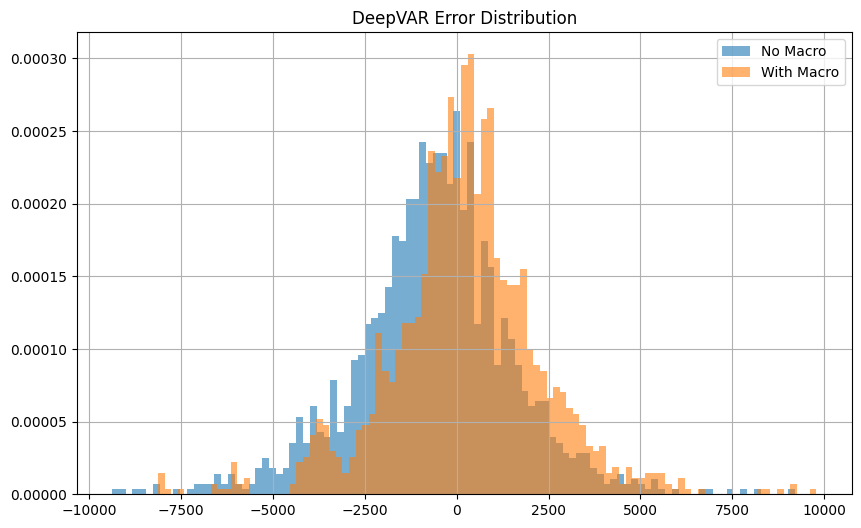

In [48]:
plt.figure(figsize=(10,6))
plt.hist(all_err_1, bins=100, density=True, alpha=0.6, label="No Macro")
plt.hist(all_err_2, bins=100, density=True, alpha=0.6, label="With Macro")
plt.legend()
plt.title("DeepVAR Error Distribution")
plt.grid(True)
plt.show()

/tmp/ipython-input-298335508.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([np.abs(all_err_1), np.abs(all_err_2)], labels=["No Macro", "With Macro"])


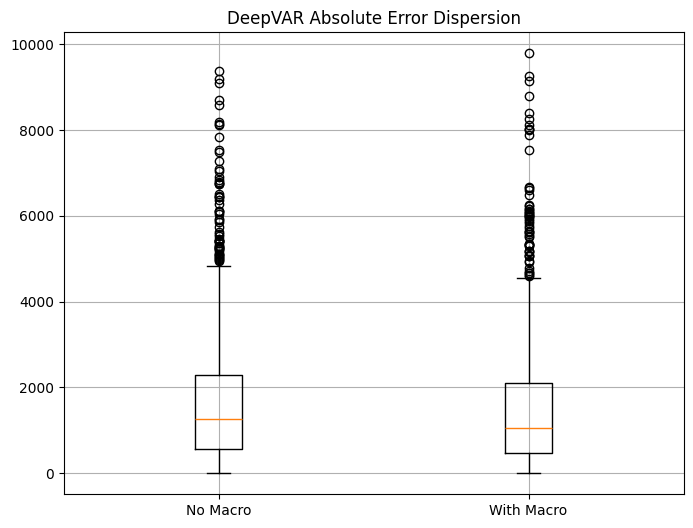

In [49]:
plt.figure(figsize=(8,6))
plt.boxplot([np.abs(all_err_1), np.abs(all_err_2)], labels=["No Macro", "With Macro"])
plt.title("DeepVAR Absolute Error Dispersion")
plt.grid(True)
plt.show()


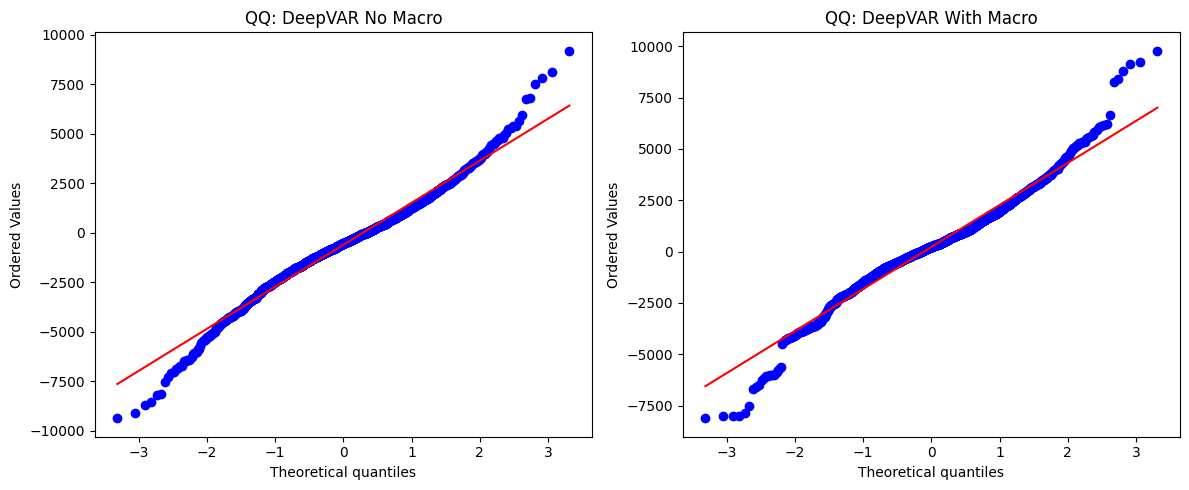

In [50]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
stats.probplot(all_err_1, dist="norm", plot=plt)
plt.title("QQ: DeepVAR No Macro")

plt.subplot(1,2,2)
stats.probplot(all_err_2, dist="norm", plot=plt)
plt.title("QQ: DeepVAR With Macro")

plt.tight_layout()
plt.show()